In [65]:
import os
import sys

sys.path.append(os.path.realpath('..'))

import pandas as pd
pd.options.display.max_colwidth = 100

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter

def keth(x, pos):
    'The two args are the value and tick position'
    return '%1.fK' % (x * 1e-3)
keth_formatter = FuncFormatter(keth)

### How to get cefi-defi trades
1. We get all the transactions which have paid rewards directly to the coinbase address
2. Of those transactions we check the number of token transfers and number of unique tokens transferred

We assume that if a transaction pays directly to coinbase address
And has 2 token transfers and 2 unique tokens transferred then it should be a cefi-defi trade

**Note**: This is a very crude assumption there is possibility of false negative but we are doing this analysis to estimate a lower bound on these activities

In [2]:
df = pd.read_gbq(
"""
select concat(unique_token, num_token_transfers) as cefidefi, concat(CAST(EXTRACT(MONTH from timestamp) as string), "-", CAST(EXTRACT(YEAR from timestamp) as string)) as monthyear, sum(reward) as total_reward
from
(select number, miner, timestamp, value/pow(10, 18) as reward, token.num_token_transfers, token.unique_token, token.transaction_hash from
(SELECT number, timestamp, miner 
FROM `bigquery-public-data.crypto_ethereum.blocks` 
WHERE DATE(timestamp) > "2022-10-01") as b
inner join 
(
  SELECT block_number, to_address, from_address, value, transaction_hash, transaction_index FROM `bigquery-public-data.crypto_ethereum.traces` 
WHERE DATE(block_timestamp) > "2022-10-01"
and value > 0
and status = 1
) as tr
on b.number = tr.block_number and tr.to_address = b.miner
inner join
(
  SELECT transaction_hash, count(1) as num_token_transfers, count(distinct(token_address)) as unique_token FROM `bigquery-public-data.crypto_ethereum.token_transfers` 
WHERE DATE(block_timestamp) > "2022-10-01"
group by transaction_hash
) as token
on tr.transaction_hash = token.transaction_hash)
group by 1, 2
"""
)

/Users/ankitchiplunkar/projects/crypto_charts/venv/lib/python3.10/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [3]:
df['cefi-defi'] = np.where(df['cefidefi'] == '22', 'CeFi-DeFi', 'Others')

In [4]:
df_cefidefi = df.groupby(['monthyear', 'cefi-defi']).sum()['total_reward'].reset_index()
to_plot = df_cefidefi.pivot(index="monthyear", columns="cefi-defi", values="total_reward")
new_order = ['10-2022', '11-2022', '12-2022', '1-2023', '2-2023']
to_plot = to_plot.reindex(new_order, axis=0)

/var/folders/vm/n0lnd6g946l4l6jlzv2954m40000gn/T/ipykernel_40258/1948779259.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_cefidefi = df.groupby(['monthyear', 'cefi-defi']).sum()['total_reward'].reset_index()


Text(0, 0.5, 'Rewards to Coinbase in ETH')

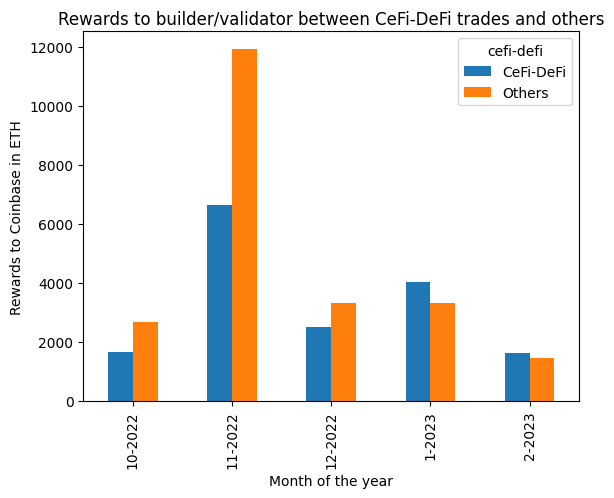

In [5]:
ax = to_plot.plot.bar()
ax.set_title('Rewards to builder/validator between CeFi-DeFi trades and others')
ax.set_xlabel('Month of the year')
ax.set_ylabel('Rewards to Coinbase in ETH')

Text(0.5, 0, 'Month of the year')

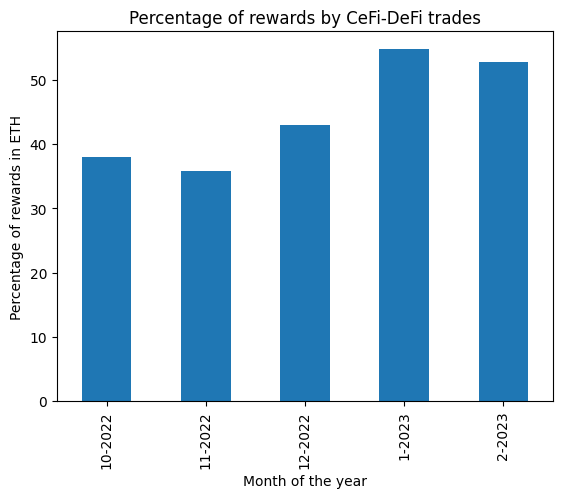

In [6]:
to_plot['pct_cefidefi'] = to_plot['CeFi-DeFi']*100/(to_plot['CeFi-DeFi']+to_plot['Others'])
ax = to_plot.plot(y='pct_cefidefi', kind='bar', legend=False)
ax.set_title('Percentage of rewards by CeFi-DeFi trades')
ax.set_ylabel('Percentage of rewards in ETH')
ax.set_xlabel('Month of the year')

### Split between cefi-defi arbs vs others 
54% of coinbase rewards are due to cefi-defi trades

In [7]:
df_cefidefi.groupby('cefi-defi').sum()

/var/folders/vm/n0lnd6g946l4l6jlzv2954m40000gn/T/ipykernel_40258/3082638410.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_cefidefi.groupby('cefi-defi').sum()


,total_reward
cefi-defi,
CeFi-DeFi,16448.719959
Others,22702.448848


In [8]:
15775.420342/(22135.540249+15775.420342)

0.4161176634955817

### Validator payment by priority fees

In [9]:
df_priority_validator_fees = pd.read_gbq("""
SELECT concat(
    CAST(EXTRACT(MONTH from block_timestamp) as string), "-", CAST(EXTRACT(YEAR from block_timestamp) as string)
    ) as monthyear, 
    sum((receipt_gas_used*cast(max_priority_fee_per_gas as numeric))/pow(10, 18)) as reward 
    FROM `bigquery-public-data.crypto_ethereum.transactions` 
WHERE DATE(block_timestamp) > "2022-10-01" 
group by 1
""")

In [10]:
df_priority_validator_fees['fee_type'] = 'priority_fees'

### Validator direct payments

In [11]:
df_validator_direct_payments = pd.read_gbq(
"""
select concat(
  CAST(EXTRACT(MONTH from timestamp) as string), "-", CAST(EXTRACT(YEAR from timestamp) as string)
  ) as monthyear, sum(value/pow(10, 18)) as reward from
(SELECT number, timestamp, miner 
FROM `bigquery-public-data.crypto_ethereum.blocks` 
WHERE DATE(timestamp) > "2022-10-01") as b
inner join 
(
  SELECT block_number, to_address, from_address, value, transaction_hash, transaction_index, trace_address FROM `bigquery-public-data.crypto_ethereum.traces` 
WHERE DATE(block_timestamp) > "2022-10-01"
and value > 0
and status = 1
) as tr
on b.number = tr.block_number and tr.to_address = b.miner
group by 1
""")

In [12]:
df_validator_direct_payments['fee_type'] = 'direct_payment'
df2 = pd.concat([df_validator_direct_payments, df_priority_validator_fees])
to_plot2 = df2.pivot(index="monthyear", columns="fee_type", values="reward")

<AxesSubplot: xlabel='monthyear'>

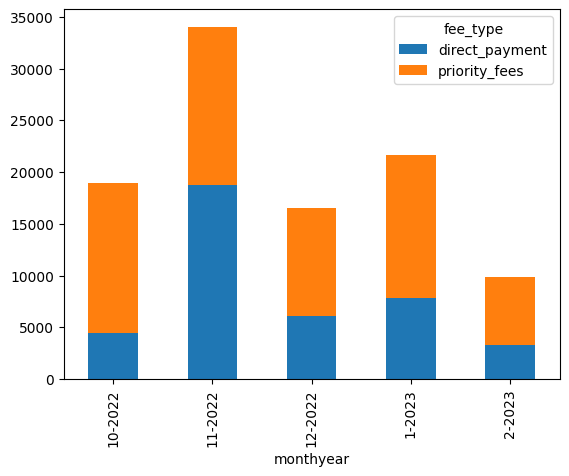

In [13]:
new_order = ['10-2022', '11-2022', '12-2022', '1-2023', '2-2023']
to_plot2 = to_plot2.reindex(new_order, axis=0)
to_plot2.plot.bar(stacked=True)

In [14]:
to_plot2

fee_type,direct_payment,priority_fees
monthyear,,
10-2022,4406.551561,14492.967331
11-2022,18730.226255,15275.633631
12-2022,6116.937283,10386.719948
1-2023,7817.461840,13869.897365
2-2023,3292.720375,6567.814225


/var/folders/vm/n0lnd6g946l4l6jlzv2954m40000gn/T/ipykernel_40258/887591418.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df3 = df2.groupby('monthyear').sum()


<AxesSubplot: xlabel='monthyear'>

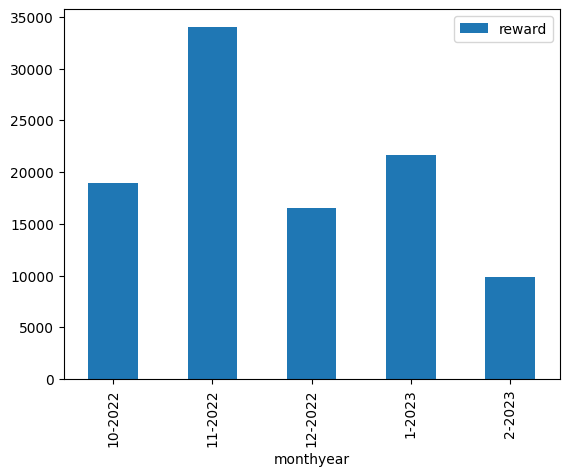

In [15]:
df3 = df2.groupby('monthyear').sum()
new_order = ['10-2022', '11-2022', '12-2022', '1-2023', '2-2023']
df3 = df3.reindex(new_order, axis=0)
df3.plot.bar()

In [16]:
df4 = df_cefidefi[df_cefidefi['cefi-defi'] == 'CeFi-DeFi']
df4 = df4.rename(columns={"cefi-defi": "type", "total_reward": "reward"})

In [17]:
df3 = df3.reset_index()
df3['type'] = 'total'

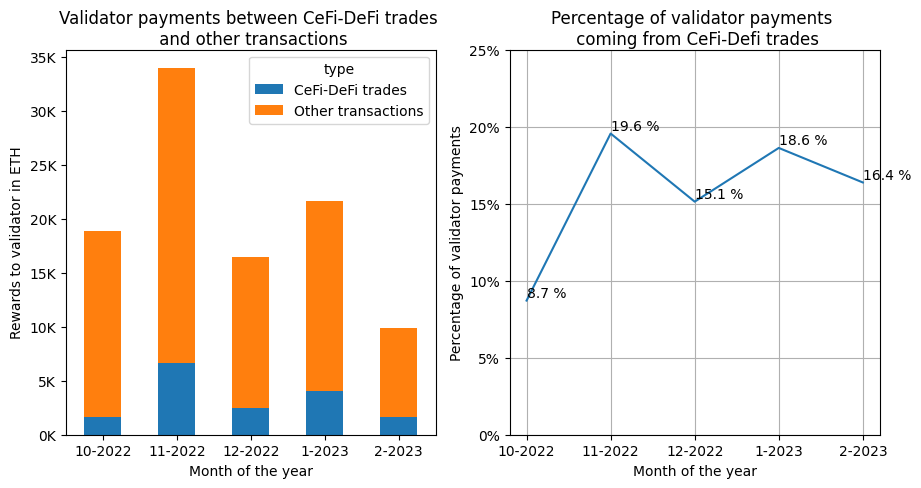

In [89]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10.5, 5))

to_plot3 = pd.concat([df3, df4]).pivot(index="monthyear", columns="type", values="reward")
to_plot3['Other transactions'] = to_plot3['total'] - to_plot3['CeFi-DeFi']
to_plot3 = to_plot3.rename(columns={"CeFi-DeFi": "CeFi-DeFi trades"})
new_order = ['10-2022', '11-2022', '12-2022', '1-2023', '2-2023']
to_plot3 = to_plot3.reindex(new_order, axis=0)
to_plot3['pct'] = to_plot3['CeFi-DeFi trades']*100/to_plot3['total']

ax = to_plot3[['CeFi-DeFi trades', 'Other transactions']].plot.bar(stacked=True, ax=ax1)
ax1.set_title('Validator payments between CeFi-DeFi trades \n and other transactions', wrap=True)
ax1.set_xlabel('Month of the year',  rotation=0)
ax1.set_ylabel('Rewards to validator in ETH')
ax1.yaxis.set_major_formatter(keth_formatter)


for tick in ax1.get_xticklabels():
    tick.set_rotation(0)
    
to_plot3['pct'].plot(grid=True, ax=ax2)
ax2.set_title('Percentage of validator payments \n coming from CeFi-Defi trades', wrap=True)
ax2.set_xlabel('Month of the year')
ax2.set_ylabel('Percentage of validator payments')
ax2.set_ylim(0, 25)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

for id, val in enumerate(to_plot3['pct']):
    ax2.text(id, val+0.2, "{:.1f} %".format(val))

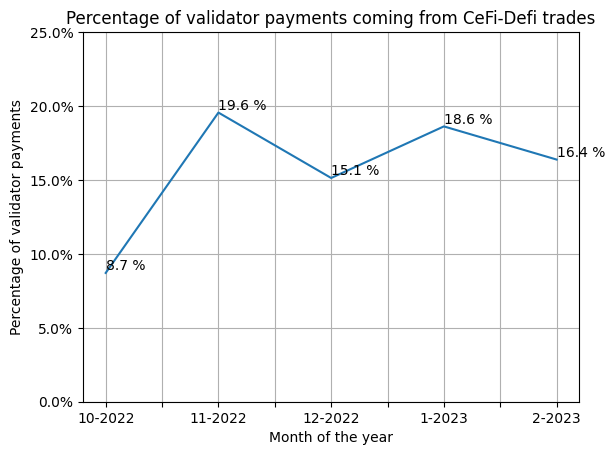

In [53]:
to_plot3['pct'] = to_plot3['CeFi-DeFi trades']*100/to_plot3['total']
ax = to_plot3['pct'].plot(grid=True)
ax.set_title('Percentage of validator payments coming from CeFi-Defi trades')
ax.set_xlabel('Month of the year')
ax.set_ylabel('Percentage of validator payments')
ax.set_ylim(0, 25)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

for id, val in enumerate(to_plot3['pct']):
    ax.text(id, val+0.2, "{:.1f} %".format(val))

In [24]:
to_plot3

type,CeFi-DeFi,total,Others,pct
monthyear,,,,
10-2022,1646.314035,18899.518892,17253.204857,8.710878
11-2022,6650.868349,34005.859886,27354.991538,19.558007
12-2022,2497.627608,16503.657231,14006.029623,15.133783
1-2023,4038.750403,21687.359205,17648.608801,18.622601
2-2023,1615.159564,9860.534599,8245.375036,16.380041
